In [12]:
import numpy as np
import matplotlib.pyplot as plt

from M3RefTracking import M3RefTracking
from DetectorConfigLoader import DetectorConfigLoader
from Detector import Detector
from DreamDetector import DreamDetector
from DreamData import DreamData

from det_classes_test import plot_ray_hits_2d
from detector_characterization import filter_ray_xy

In [13]:
base_dir = 'F:/Saclay/cosmic_data/'
det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
out_dir = 'F:/Saclay/Analysis/Cosmic Bench/9-24-24/'
run_name = 'sg1_stats_7-26-24'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'max_hv_long_1'

det_single = 'inter_grid_1'

file_nums = list(range(0, 100))

chunk_size = 100  # Number of files to process at once

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'

In [14]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)

Getting ray data...


100%|██████████| 712/712 [00:05<00:00, 139.44it/s]


In [15]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [16]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')
det.load_dream_data(data_dir, ped_dir, 10, file_nums, chunk_size, save_waveforms=True)
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 3
FEU Channels: [5, 6, 7, 8]
HV: {'drift': 800, 'resist_2': 460}
Ped files found: ['CosTb_max_hv_long_1_pedthr_240726_14H35_000_03_decoded_array.root', 'CosTb_max_hv_long_1_pedthr_240726_14H45_000_03_decoded_array.root']
Pedestal data shape: (1033, 256, 32)
Pedestal fits: (256,)
Reading in data...


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


Read in data shape: (210170, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


Fitting time: 3.7158679962158203 s
Processed chunk 1/1
Getting hits...
Hits shape: (210170, 256)


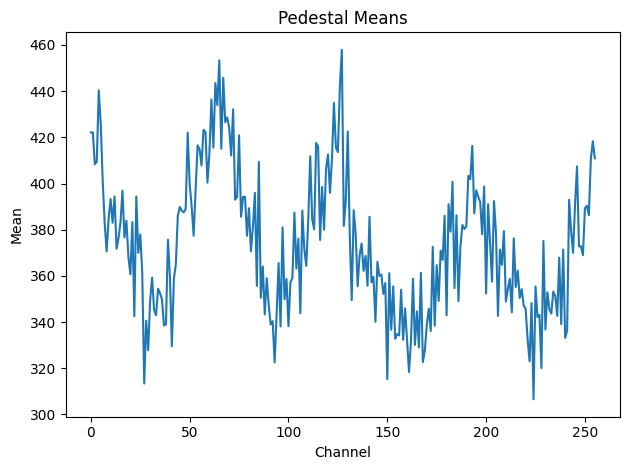

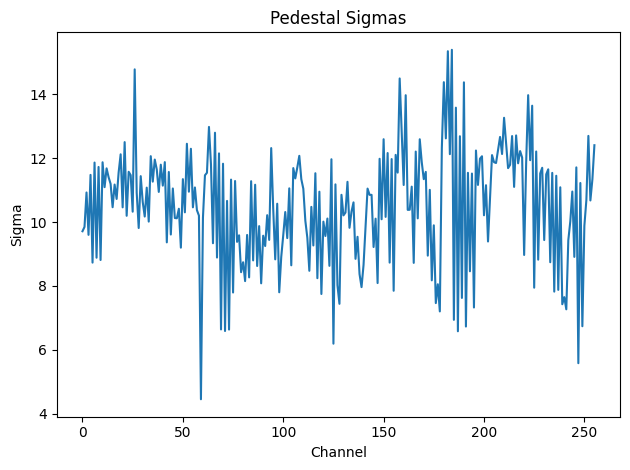

In [17]:
det.dream_data.plot_pedestals()

# Plot All Hits, No filtering

C:\Users\Dylan\PycharmProjects\saclay_micromegas\DreamData.py:435: RuntimeWarning: invalid value encountered in divide
  max_amp_div_sum = event_max_amps / event_amp_sums


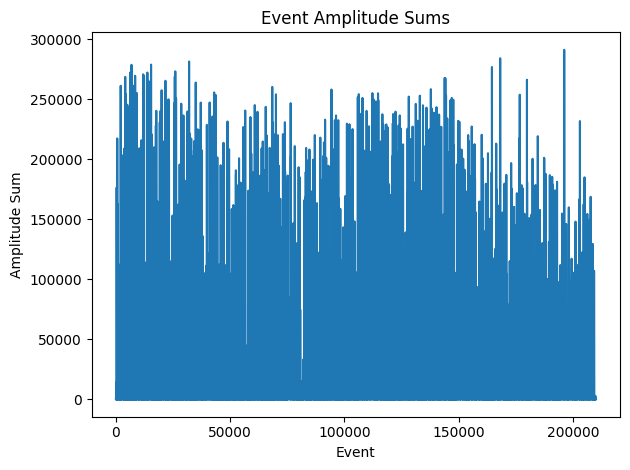

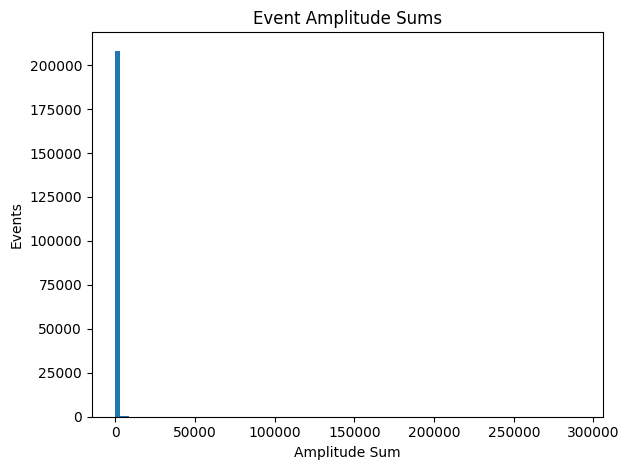

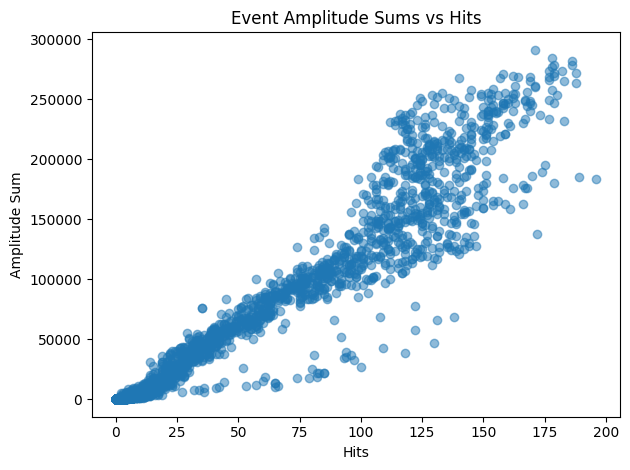

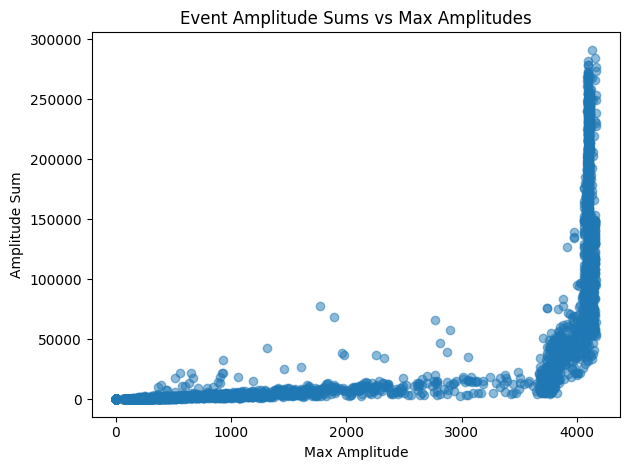

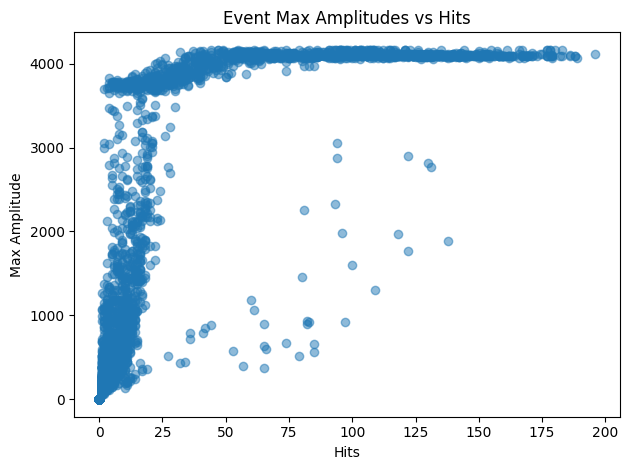

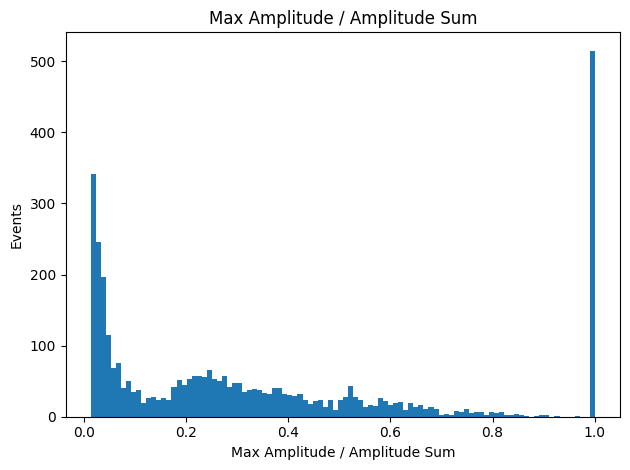

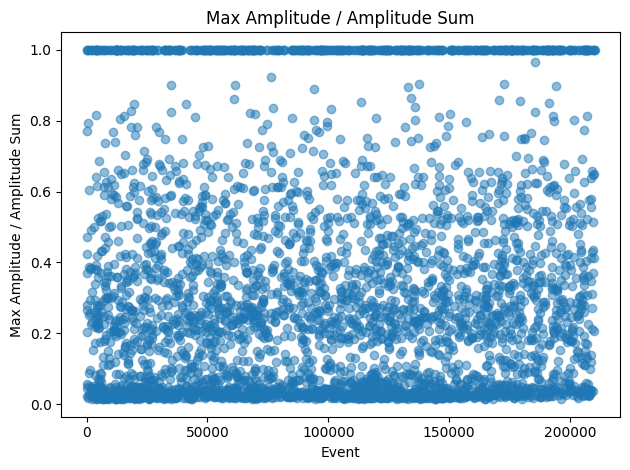

In [18]:
det.dream_data.plot_noise_metric()

Connector 5 Dead Strips: []
Connector 6 Dead Strips: []
Connector 7 Dead Strips: [167 169 171 173 179 181 183]
Connector 8 Dead Strips: [207 209 211]


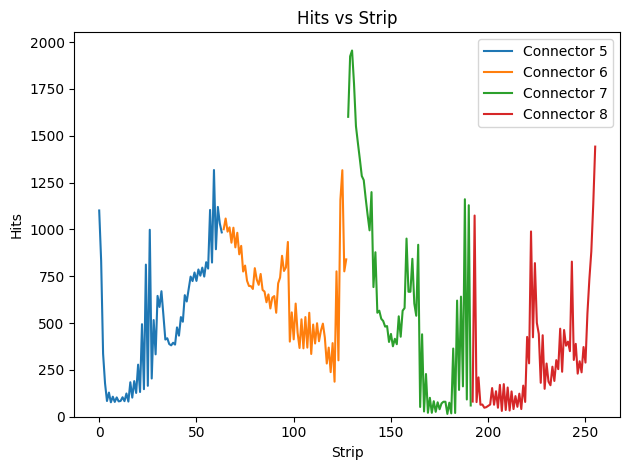

In [19]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

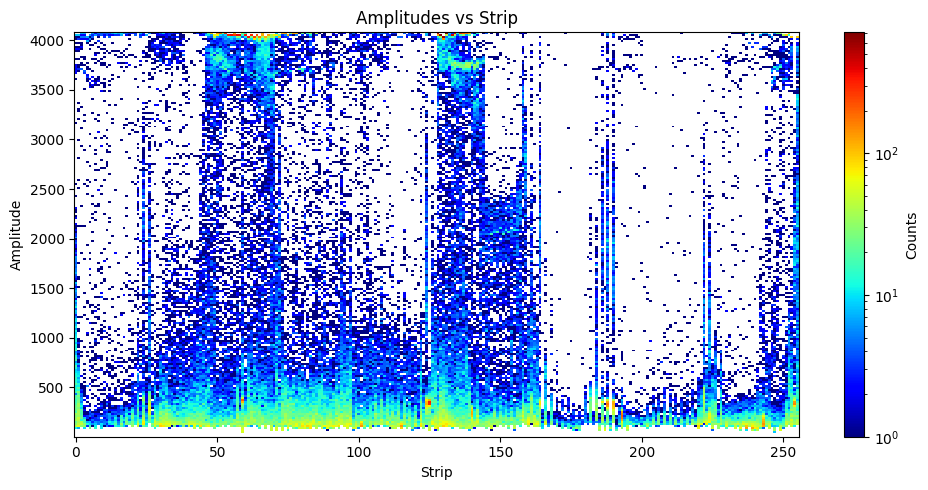

In [20]:
det.dream_data.plot_amplitudes_vs_strip()

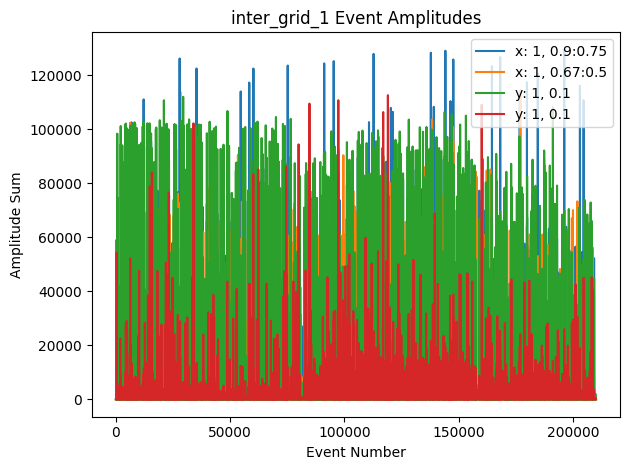

In [21]:
det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det.add_rotation(90, 'z')

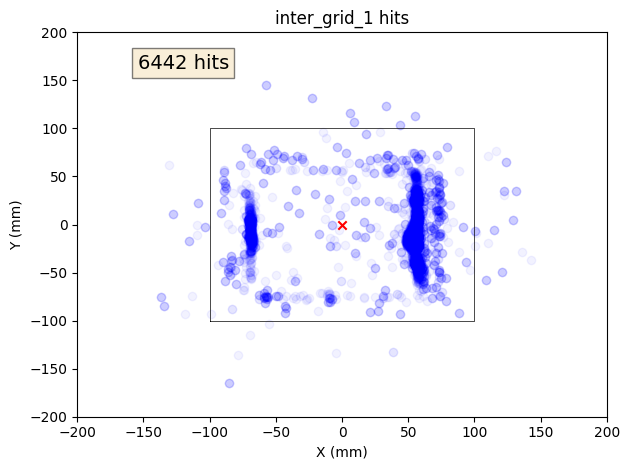

In [22]:
plot_ray_hits_2d(det, ray_data)

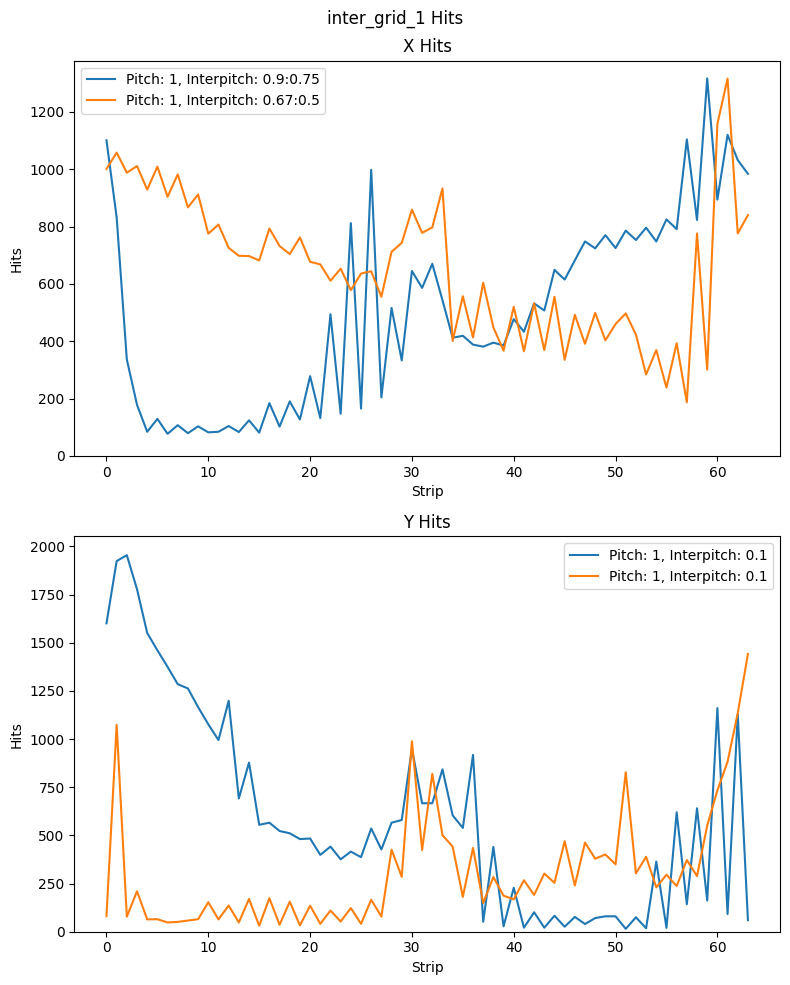

In [23]:
det.plot_hits_1d()

# Plot Where Rays Hit Edge of Detector 

First copy the det object so we can filter the hits without affecting the original object.

In [24]:
det_filter = det.copy()

In [25]:
in_range = True  # If True, filter hits in range, if False, filter hits out of range
x_ray_bounds, y_ray_bounds = [50, 70], [-90, 70]
ray_events = filter_ray_xy(ray_data, det.center[2], x_ray_bounds, y_ray_bounds)
if in_range:
    dream_data_indices = np.where(np.isin(det.dream_data.event_nums, ray_events))[0]
else:
    dream_data_indices = np.where(~np.isin(det.dream_data.event_nums, ray_events))[0]

# max_amp_thresh = [3500, 4000]
max_amp_thresh = [0, 4000]
max_amps = np.max(det.dream_data.data_amps, axis=1)
max_amp_indices = np.where((max_amps > max_amp_thresh[0]) & (max_amps < max_amp_thresh[1]))[0]
dream_data_indices = np.intersect1d(dream_data_indices, max_amp_indices)

det_filter.dream_data.filter_data(dream_data_indices)

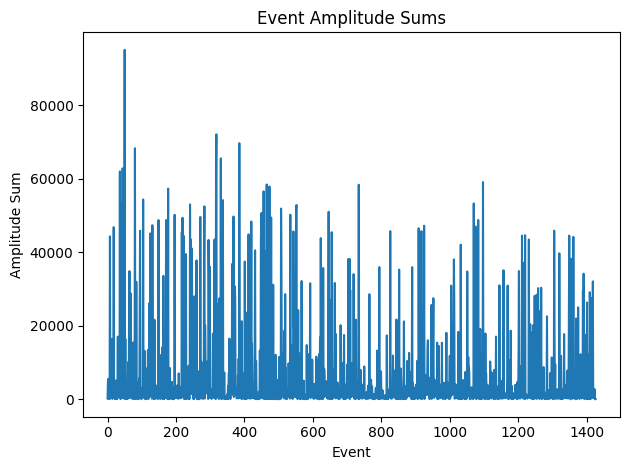

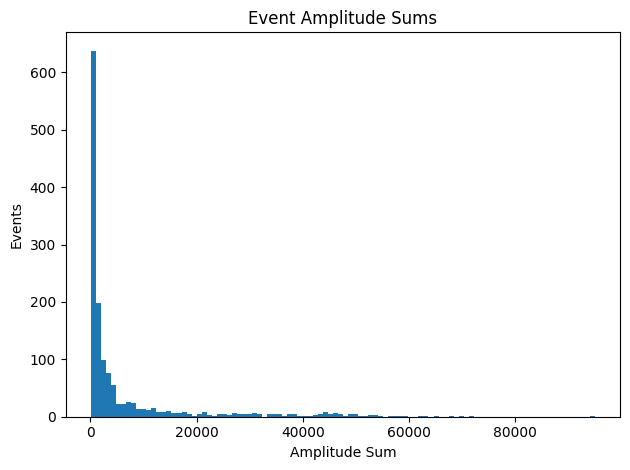

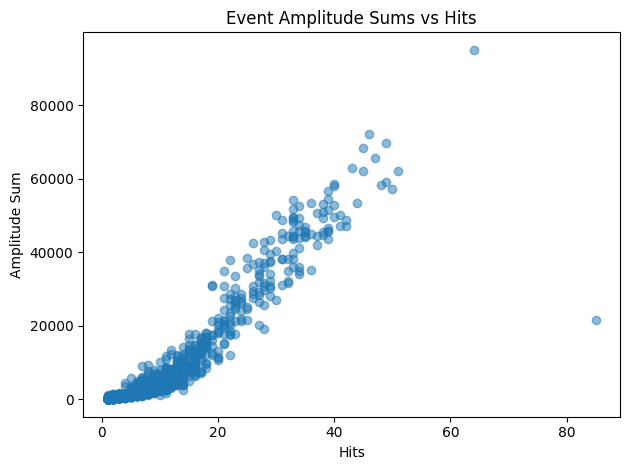

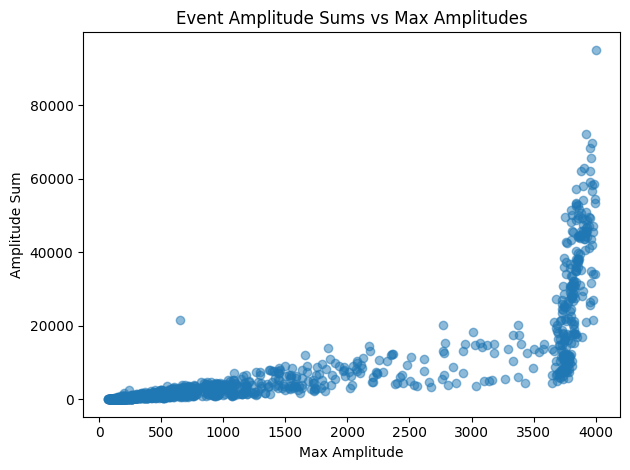

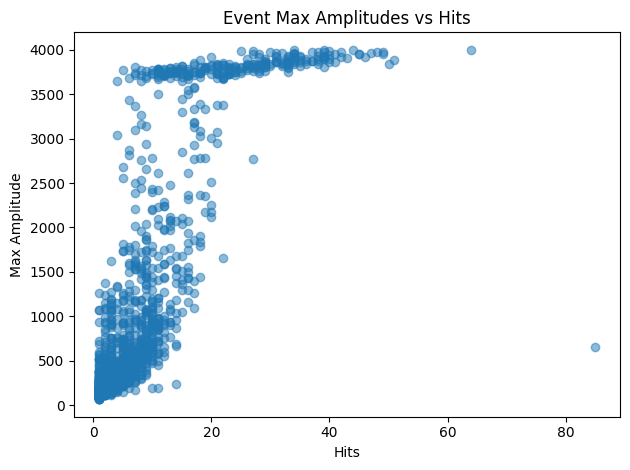

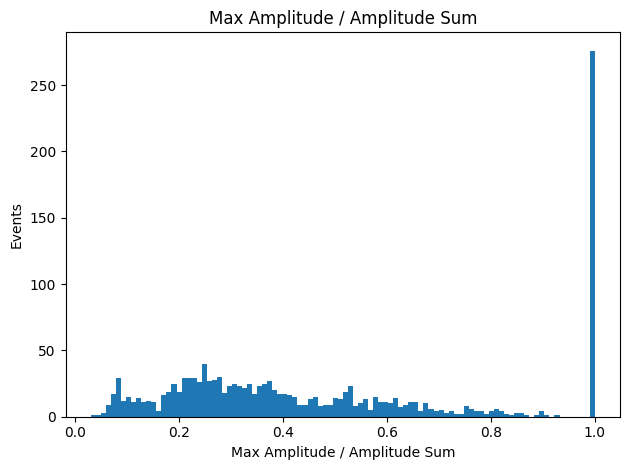

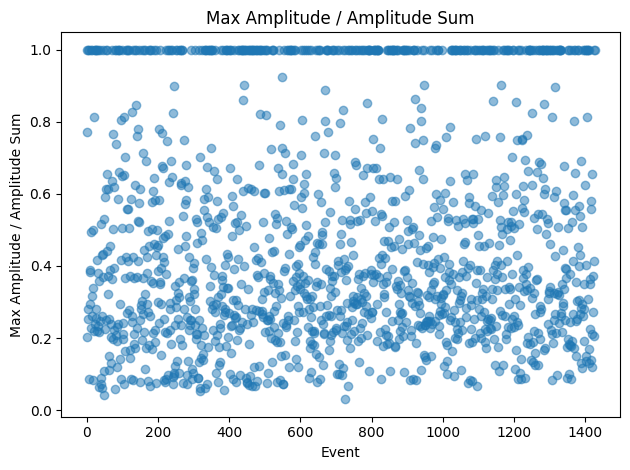

In [26]:
det_filter.dream_data.plot_noise_metric()

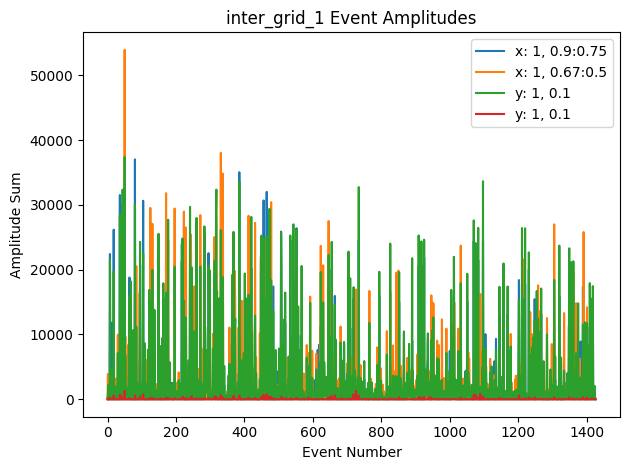

In [27]:
det_filter.make_sub_detectors()
event_nums = det_filter.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det_filter.add_rotation(90, 'z')

Connector 5 Dead Strips: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 26]
Connector 6 Dead Strips: [86]
Connector 7 Dead Strips: [143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 187 189 191]
Connector 8 Dead Strips: [192 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253]


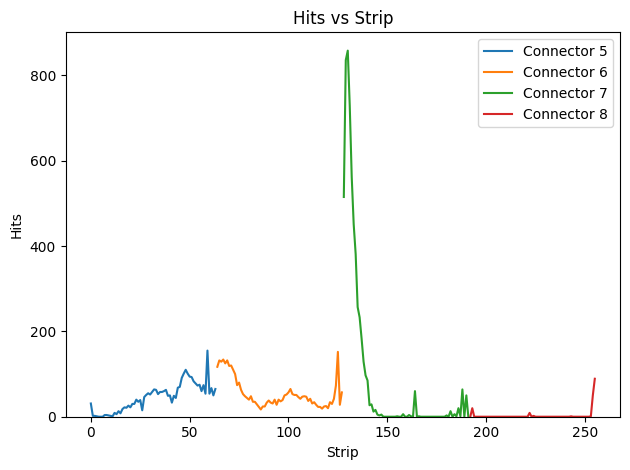

In [28]:
det_filter.dream_data.plot_hits_vs_strip(print_dead_strips=True)

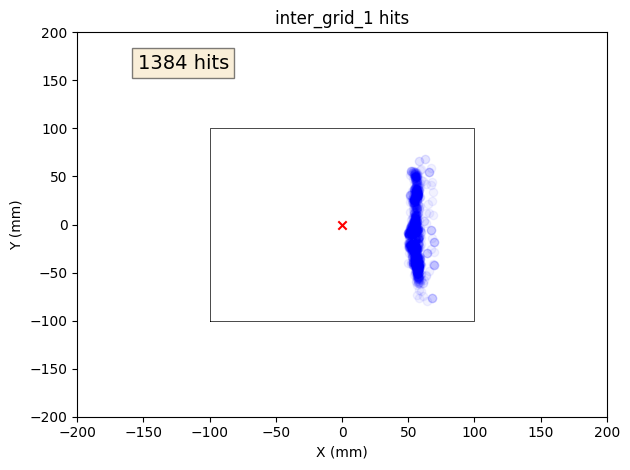

In [29]:
plot_ray_hits_2d(det_filter, ray_data)

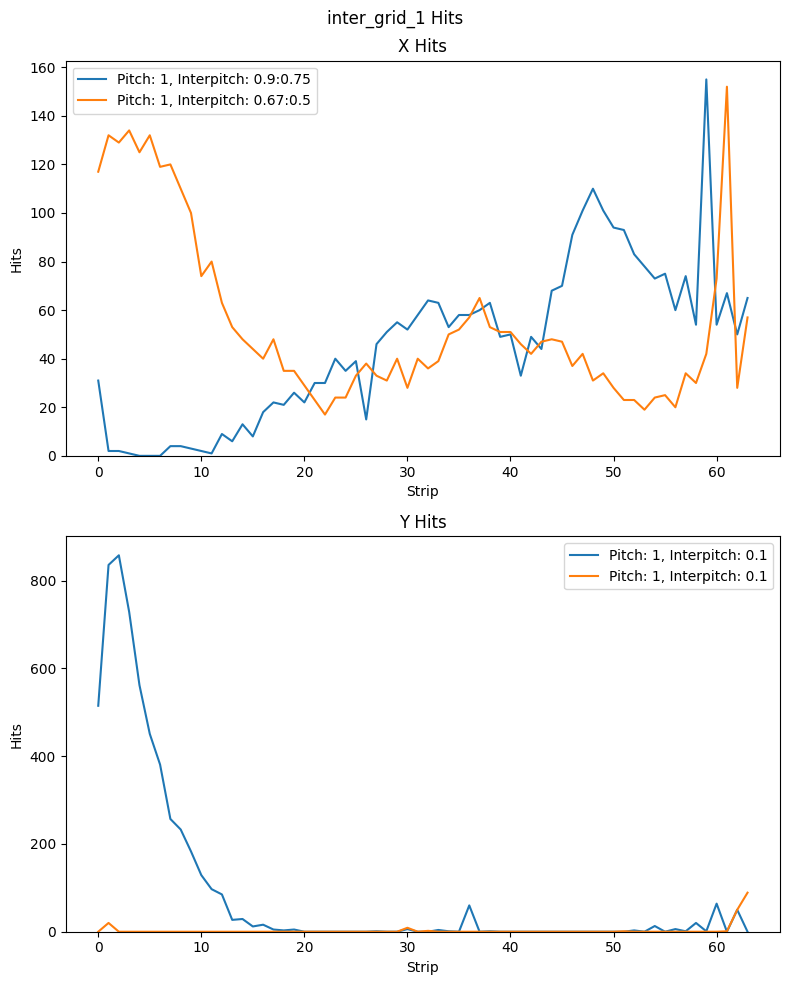

In [30]:
det_filter.plot_hits_1d()

In [31]:
print(len(det_filter.dream_data.hits))

1427


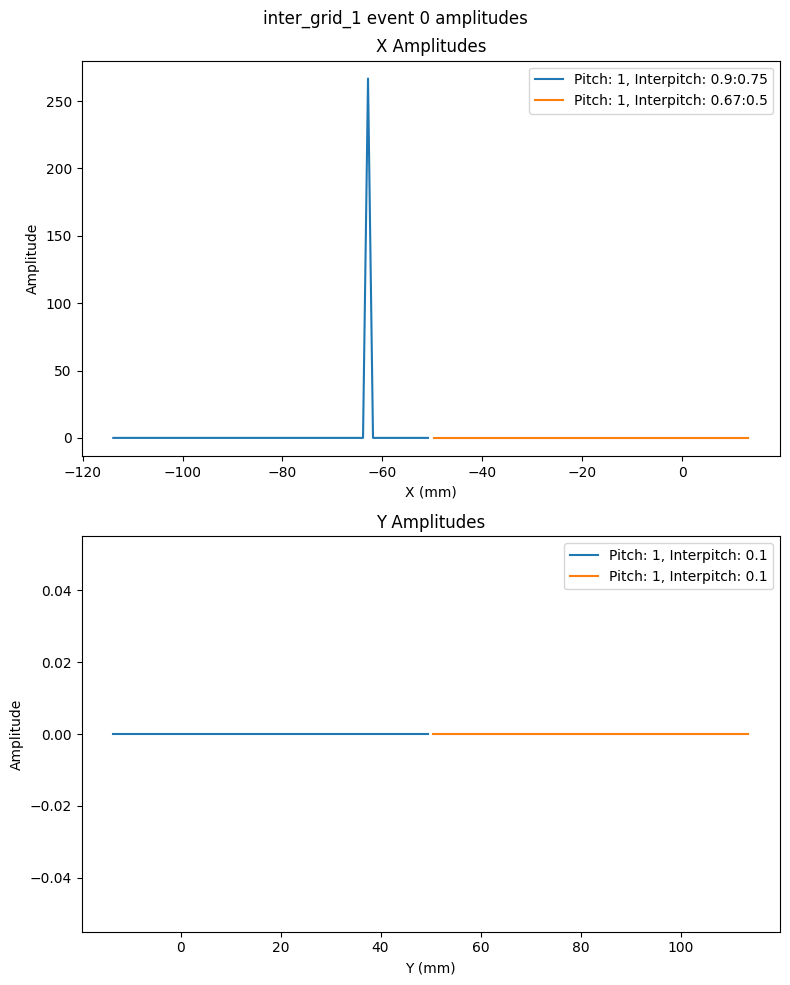

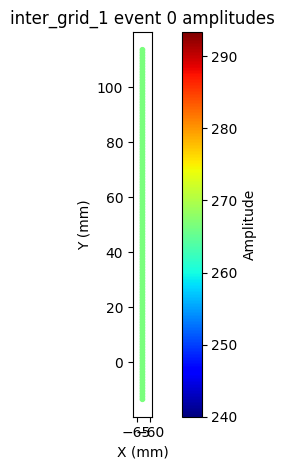

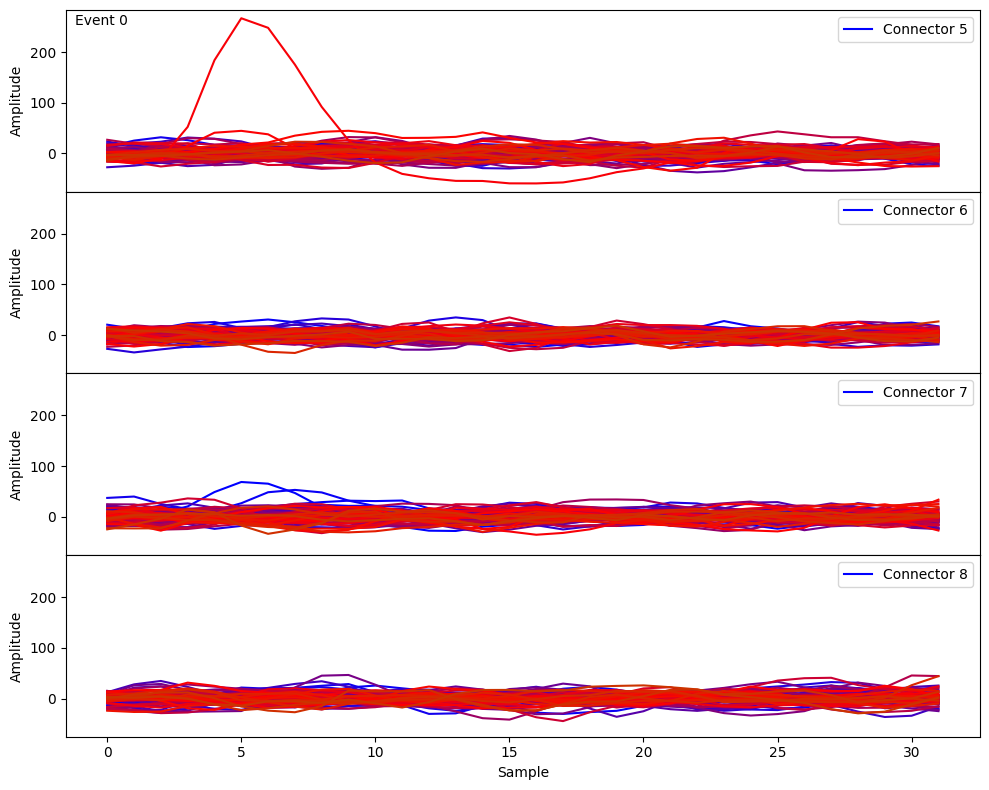

In [32]:
for event_num in range(min(len(det_filter.dream_data.hits), 1)):
    det_filter.plot_event_1d(event_num)
    det_filter.plot_event_2d(event_num)
    det_filter.dream_data.plot_waveforms(event_num)

In [ ]:
det_filter = None  # Clear det_filter object to free up memory

# Plot Where Max Amplitude is Under 3500

In [33]:
det_filter2 = det.copy()

In [34]:
in_range = False  # If True, filter hits in range, if False, filter hits out of range
x_ray_bounds, y_ray_bounds = [50, 70], [-90, 70]
ray_events = filter_ray_xy(ray_data, det.center[2], x_ray_bounds, y_ray_bounds)
if in_range:
    dream_data_indices = np.where(np.isin(det.dream_data.event_nums, ray_events))[0]
else:
    dream_data_indices = np.where(~np.isin(det.dream_data.event_nums, ray_events))[0]

# max_amp_thresh = [3500, 4000]
max_amp_thresh = [0, 3500]
max_amps = np.max(det.dream_data.data_amps, axis=1)
max_amp_indices = np.where((max_amps > max_amp_thresh[0]) & (max_amps < max_amp_thresh[1]))[0]
dream_data_indices = np.intersect1d(dream_data_indices, max_amp_indices)

det_filter2.dream_data.filter_data(dream_data_indices)

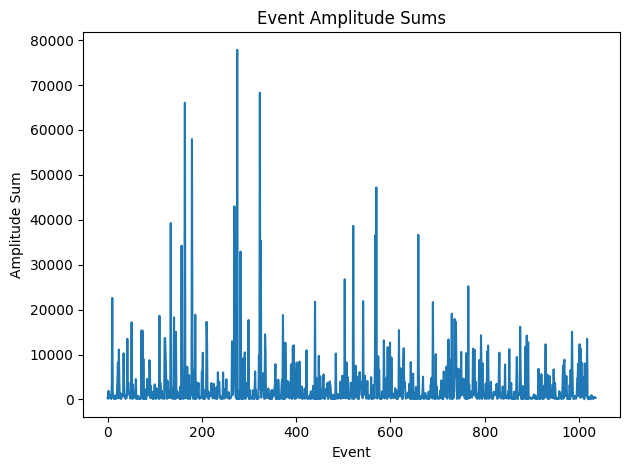

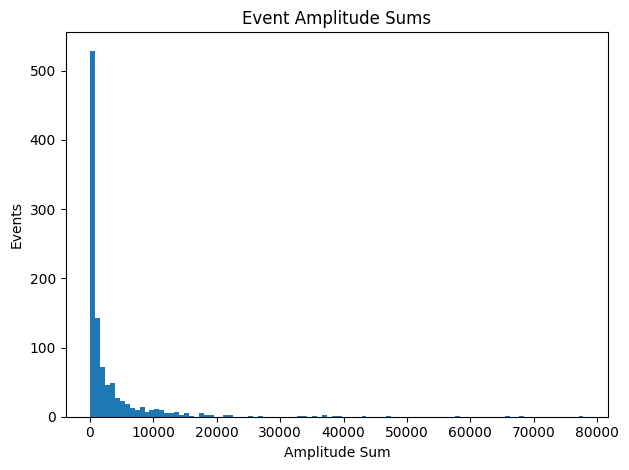

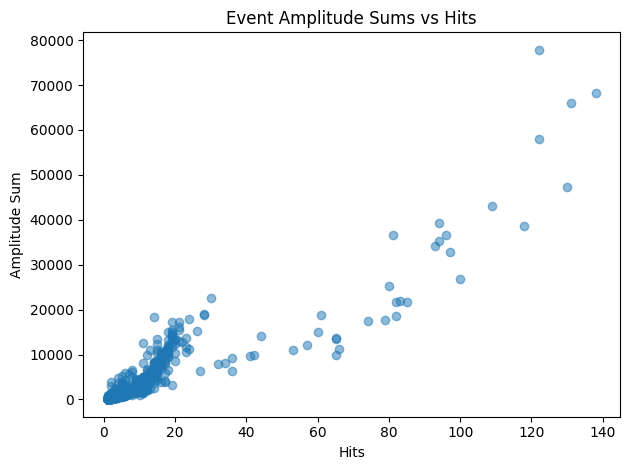

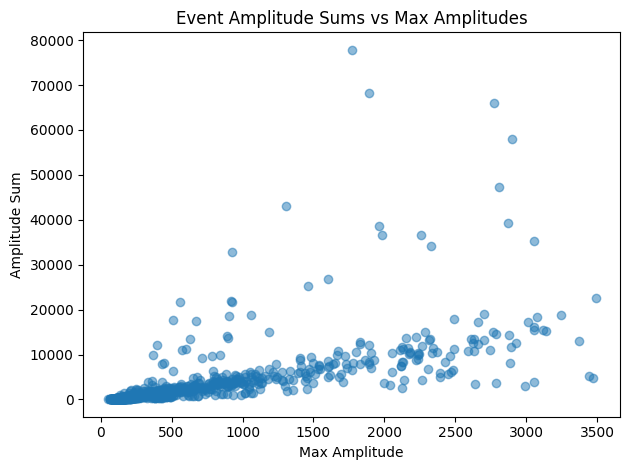

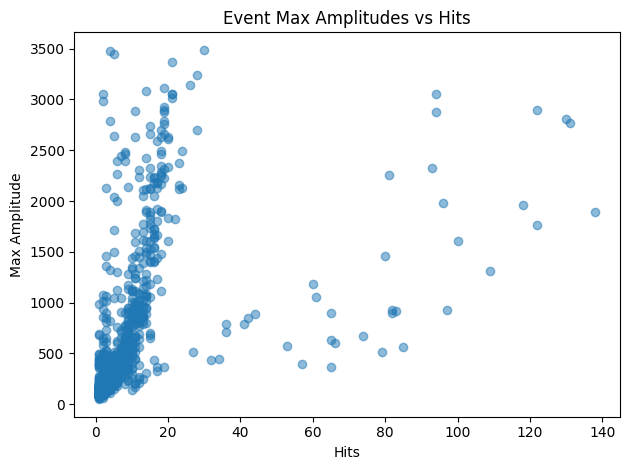

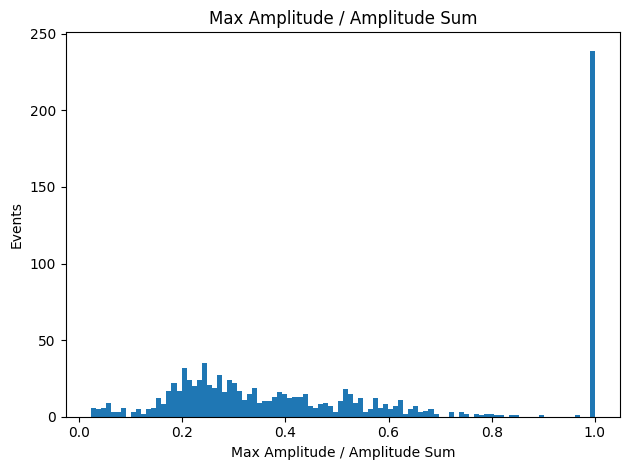

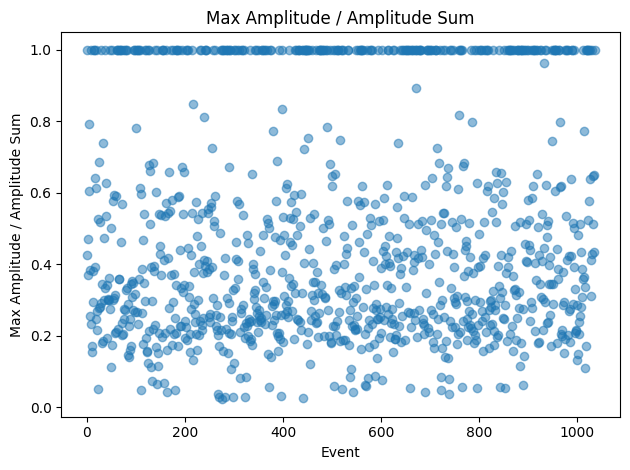

In [36]:
det_filter2.dream_data.plot_noise_metric()

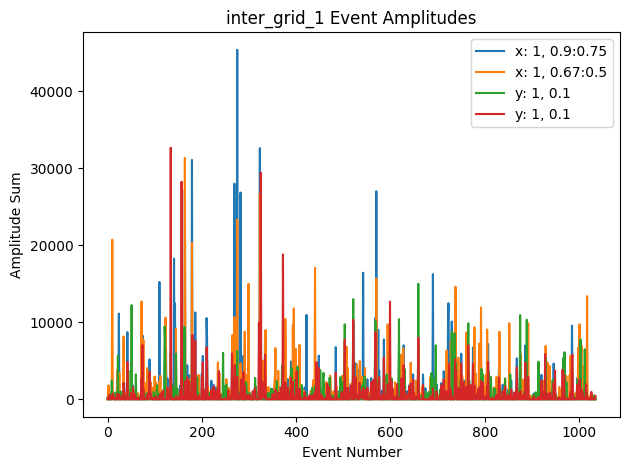

In [40]:
det_filter2.make_sub_detectors()
event_nums = det_filter2.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det_filter2.add_rotation(90, 'z')

Connector 5 Dead Strips: []
Connector 6 Dead Strips: []
Connector 7 Dead Strips: [168 170 172 174 175 176 178 180]
Connector 8 Dead Strips: [192]


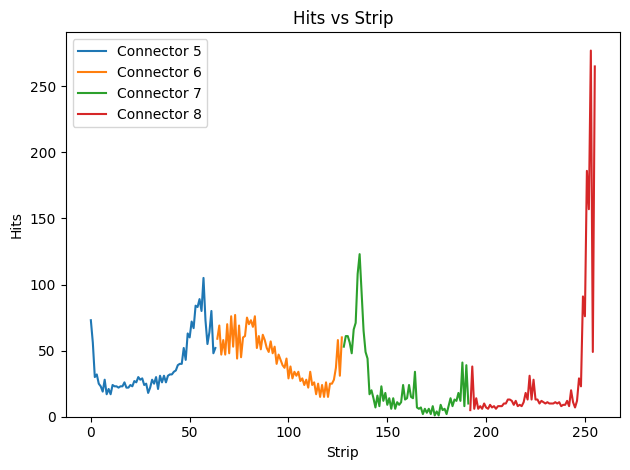

In [41]:
det_filter2.dream_data.plot_hits_vs_strip(print_dead_strips=True)

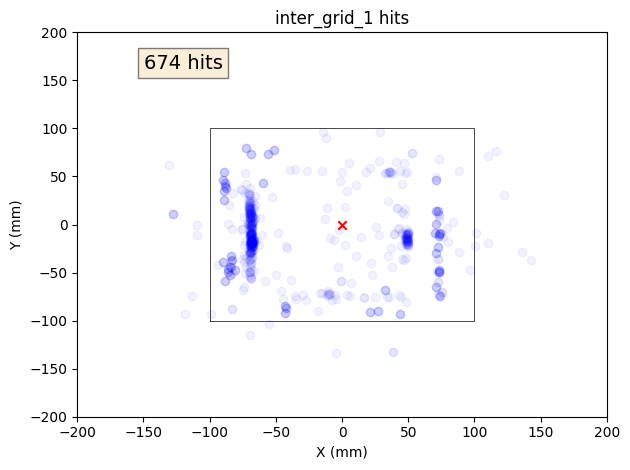

In [42]:
plot_ray_hits_2d(det_filter2, ray_data)

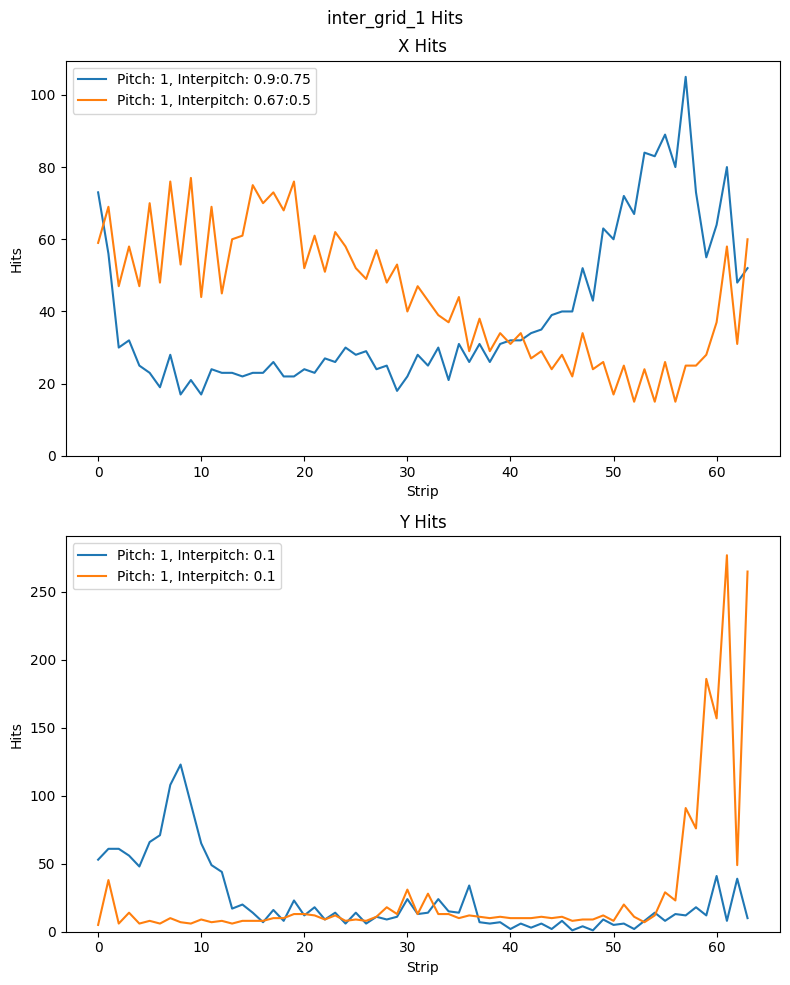

In [43]:
det_filter2.plot_hits_1d()

In [44]:
print(len(det_filter2.dream_data.hits))

1036


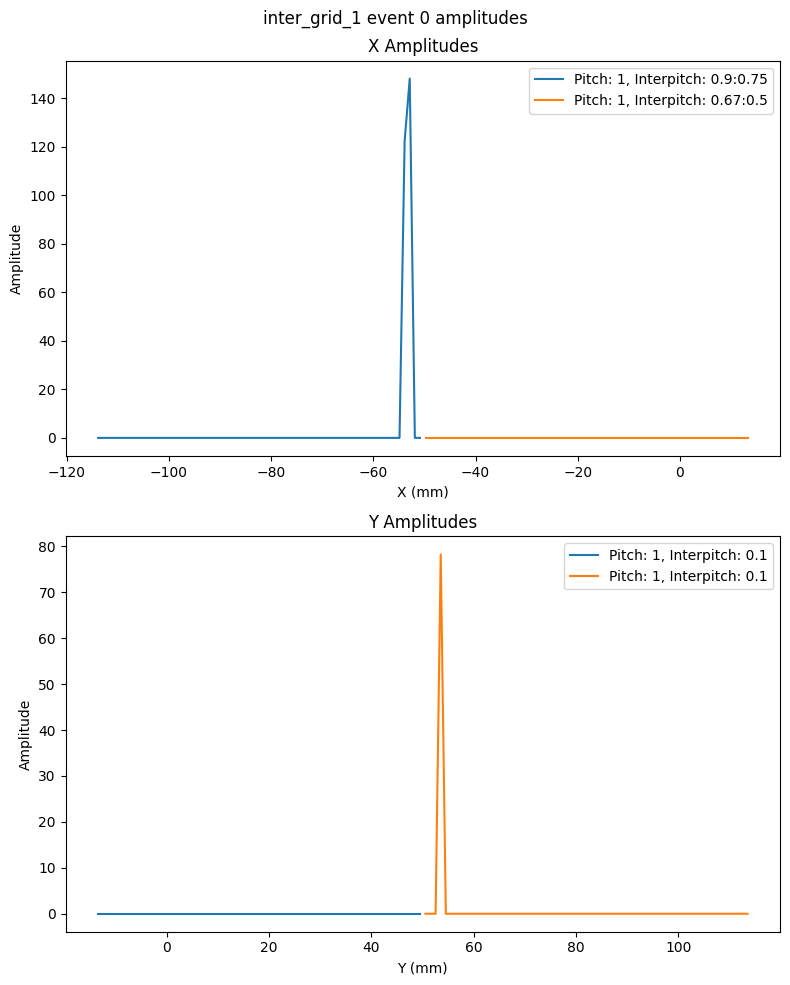

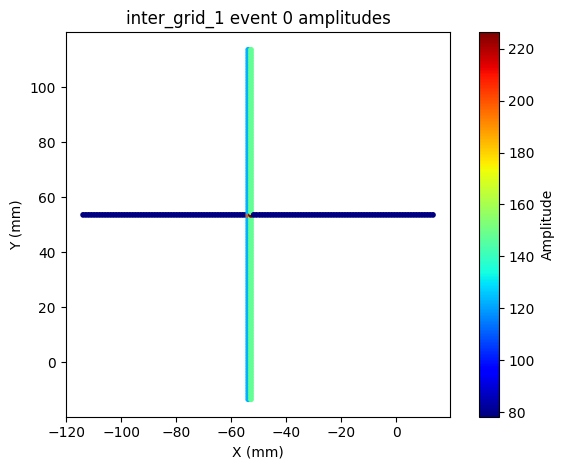

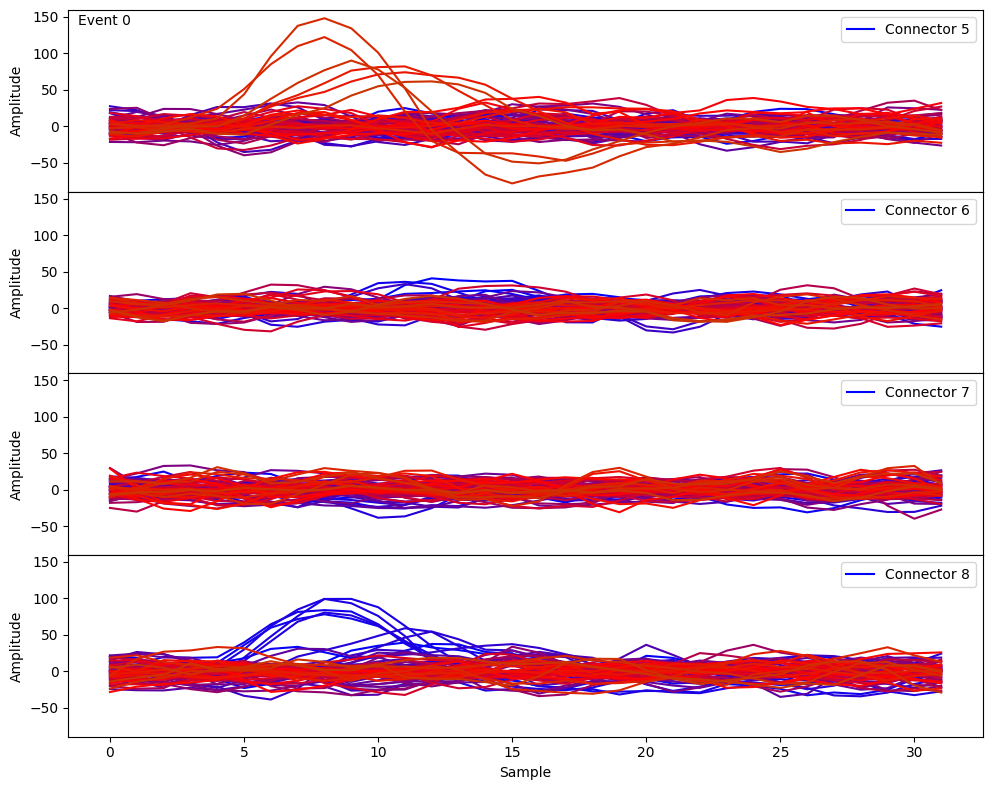

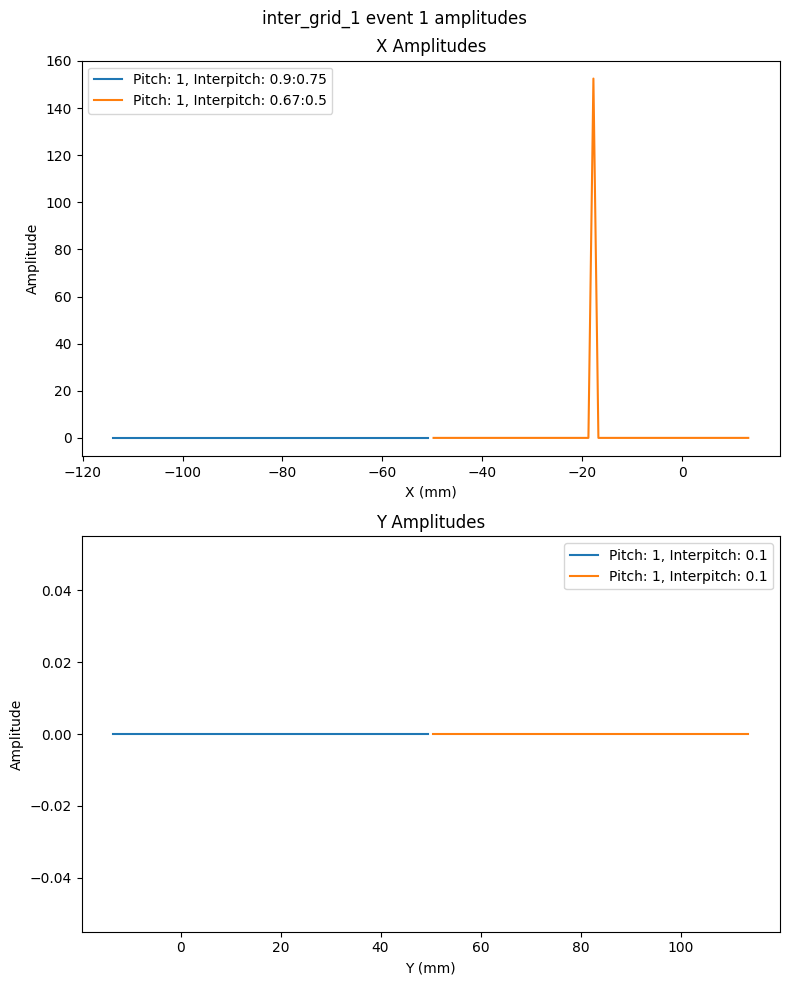

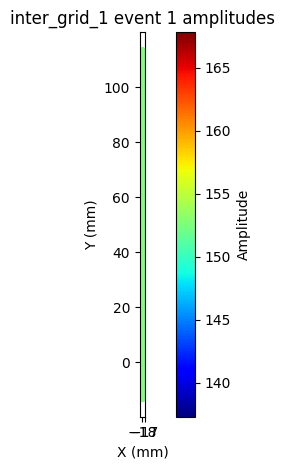

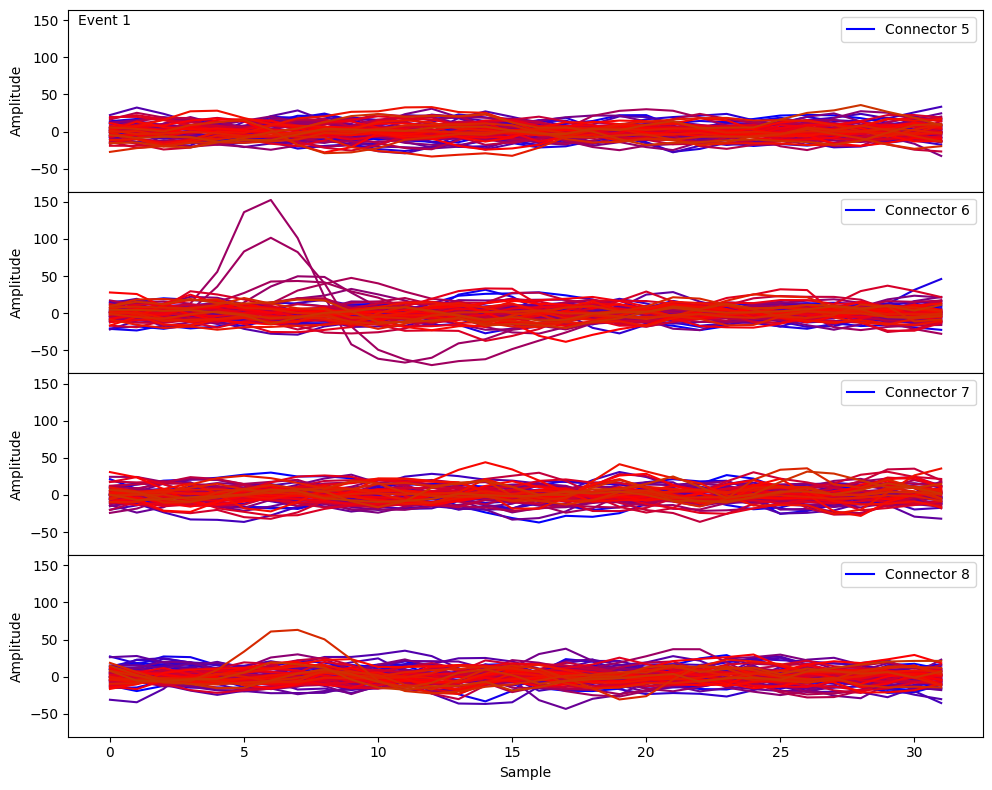

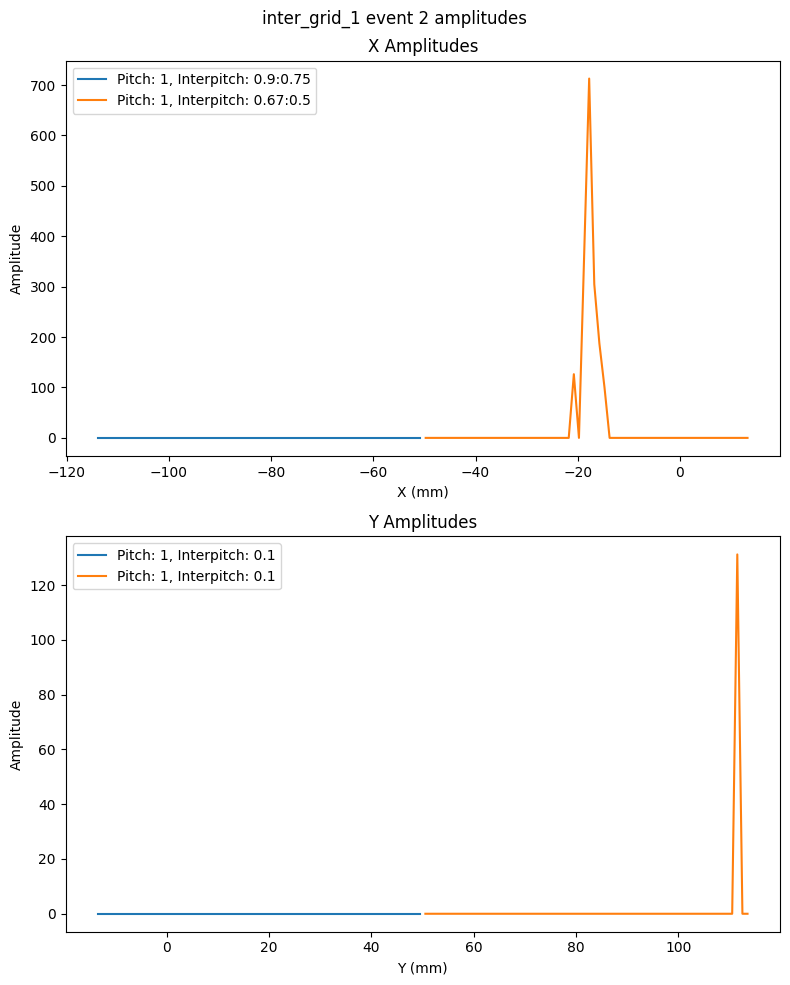

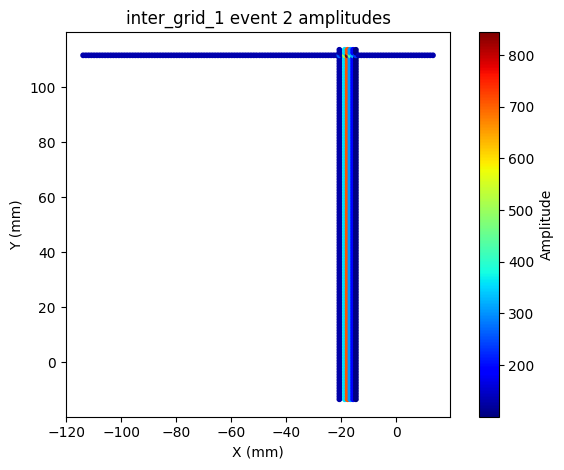

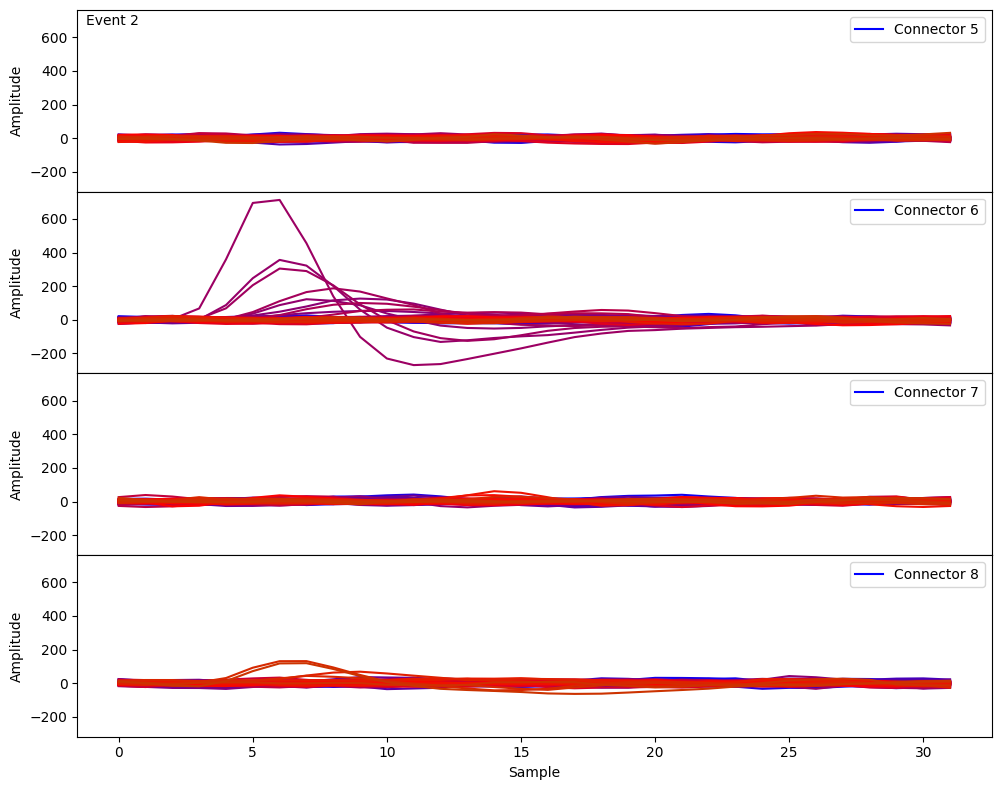

In [45]:
for event_num in range(min(len(det_filter2.dream_data.hits), 3)):
    det_filter2.plot_event_1d(event_num)
    det_filter2.plot_event_2d(event_num)
    det_filter2.dream_data.plot_waveforms(event_num)

In [ ]:
det_filter2 = None  # Clear det_filter2 object to free up memory